<a href="https://colab.research.google.com/github/LabdhiSheth/Deep-Learning-lab-work/blob/main/CIFAR10_using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 18BCE101 Labdhi Sheth
Deep Learning practical-4

Aim:
CIFAR10 classification dataset using Tranfer Learning.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 


In [ ]:
import tensorflow
from tensorflow import keras
from keras.applications.xception import Xception, preprocess_input
from keras.layers import Dense, MaxPool2D, Conv2D, Dropout, Flatten, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.models import Sequential
from keras.datasets import cifar10
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

Loading the data

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


In Keras Xception is a deep convolutional neural network architecture that involves Depthwise Separable Convolutions

Creating a function to preprocess X for xception and converting Y into one-hot encoding 

In [ ]:
def preprocess_data(X, Y):
    X = preprocess_input(X)
    Y = np_utils.to_categorical(Y)
    return X, Y

In [ ]:
# for calculating various metrics
test_target = y_test

x_train, y_train = preprocess_data(X_train, y_train)
x_test, y_test = preprocess_data(X_test, y_test)

Building a model based on Xception using Transfer Learning and adding our own classifier on top of it

In [ ]:
# weights are initialized 
initializer = keras.initializers.he_normal()
input_tensor = keras.Input(shape=(32, 32, 3))

# resize images to the image size on which the network was pre-trained (i.e 72 X 72)
resized_images = keras.layers.Lambda(lambda image: tensorflow.image.resize(image, (72, 72)))(input_tensor)
model = Xception(include_top=False,weights='imagenet',input_tensor=resized_images,input_shape=(72, 72, 3),pooling='max')

# make the weights and biases of the base model non-trainable by "freezing" each layer of the DenseNet201 network
for layer in model.layers:
    layer.trainable = False
output = model.layers[-1].output

# reshape the output feature map of the base model before passing the data on to the Dense layers of the classifier head
flatten = Flatten()
output = flatten(output)
layer_256 = Dense(units=256,activation='relu',kernel_initializer=initializer,kernel_regularizer=keras.regularizers.l2())

output = layer_256(output)

dropout = Dropout(0.3)
output = dropout(output)

softmax = Dense(units=10,activation='softmax',kernel_initializer=initializer,kernel_regularizer=keras.regularizers.l2())
output = softmax(output)

model = keras.models.Model(inputs=input_tensor, outputs=output)


83689472/83683744 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

Creating training and validation generator and fitting the model

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)
train_generator = train_datagen.flow(x_train,y_train,batch_size=32)

val_datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)
val_generator = val_datagen.flow(x_test,y_test,batch_size=32)

train_steps_per_epoch = x_train.shape[0] // 32
val_steps_per_epoch = x_test.shape[0] // 32

history = model.fit(train_generator,steps_per_epoch=train_steps_per_epoch,validation_data=val_generator,validation_steps=val_steps_per_epoch,epochs=5,shuffle=True,verbose=1)

Epoch 1/5
1562/1562 [==============================] - 75s 26ms/step - loss: 5.7773 - accuracy: 0.5620 - val_loss: 3.0927 - val_accuracy: 0.7182
Epoch 2/5
1562/1562 [==============================] - 39s 25ms/step - loss: 2.6713 - accuracy: 0.7227 - val_loss: 1.7848 - val_accuracy: 0.7386
Epoch 3/5
1562/1562 [==============================] - 40s 26ms/step - loss: 1.6279 - accuracy: 0.7412 - val_loss: 1.3016 - val_accuracy: 0.7405
Epoch 4/5
1562/1562 [==============================] - 40s 25ms/step - loss: 1.2210 - accuracy: 0.7516 - val_loss: 1.1116 - val_accuracy: 0.7397
Epoch 5/5
1562/1562 [==============================] - 40s 26ms/step - loss: 1.0582 - accuracy: 0.7519 - val_loss: 1.0372 - val_accuracy: 0.7418


Prediction

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

313/313 [==============================] - 7s 21ms/step - loss: 1.0340 - accuracy: 0.7416
Test Accuracy: 74.16%


In [ ]:
prediction = model.predict(x_test)
prediction = np.argmax(prediction, axis=1)
print(prediction)
print(prediction.shape)

[3 8 8 ... 5 0 7]
(10000,)


In [ ]:
#calculating various metrics
print("Accuracy Score",metrics.accuracy_score(test_target, prediction, normalize= True))
print("Classification Report",metrics.classification_report(test_target, prediction))
print("Confusion Matrix",metrics.confusion_matrix(test_target,prediction))

Accuracy Score 0.7416
Classification Report               precision    recall  f1-score   support

           0       0.75      0.74      0.75      1000
           1       0.81      0.85      0.83      1000
           2       0.74      0.68      0.71      1000
           3       0.57      0.67      0.62      1000
           4       0.61      0.74      0.67      1000
           5       0.76      0.67      0.71      1000
           6       0.74      0.75      0.75      1000
           7       0.84      0.71      0.77      1000
           8       0.80      0.86      0.83      1000
           9       0.89      0.74      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000

Confusion Matrix [[741  23  32  26  38   3  14  14  94  15]
 [ 26 851   3  25   3  10   2   2  23  55]
 [ 45   2 684  56 104  17  71  16   5   0]
 [ 16   8  42 666  67 105  64  17  12   3]
 [ 20   

Plotting the results

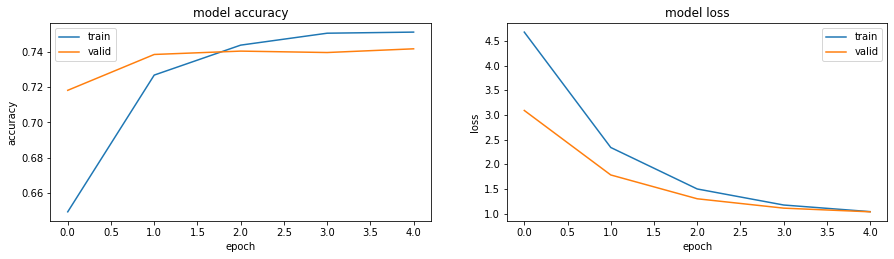

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()


# Conclusion
Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task. Transfer learning is popular in deep learning given the enormous resources required to train deep learning models or the large and challenging datasets on which deep learning models are trained. Thus in our case for classifying CIFAR10 dataset we are using Xception weights